In [1]:
import re
import numpy as np
import time
import os.path
import sys
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from io import StringIO
from Bio import SeqIO
import pysam
from pandas.plotting import scatter_matrix
import warnings
import json
import numpy as np
import subprocess
warnings.filterwarnings('ignore')
sys.executable.split('/')[-3]

'blastasm'

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [3]:
PROJECT_CODE='PRJNA573298'
BASE_PATH = f'/mnt/1TB_0/Data/Assembly/{PROJECT_CODE}/'

In [4]:

SRAs=['SRR10168373','SRR10168374', 'SRR10168375',\
     'SRR10168376','SRR10168377','SRR10168378',\
      'SRR10168379','SRR10168380','SRR10168381',\
      'SRR10168382','SRR10168383','SRR10168384',\
     'SRR10168385','SRR10168386','SRR10168387',\
      'SRR10168388','SRR10168389','SRR10168390',\
     'SRR10168391', 'SRR10168392','SRR10168393']

#'PRJNA607174'
#SRAs=['SRR12053850', 'SRR11119759', 'SRR11119760', 'SRR11119761','SRR11119762','SRR11119763',\
#      'SRR11119764','SRR11119765','SRR11119766',\
#      'SRR11119767']

In [5]:
def refstats_df(mapped_names, alb_abbr, aln_type, aln_params):
    #mp_hu_mus_megahit_default_toss_refstats.txt
    frames=[]
    for sra in SRAs:
        ref_path=BASE_PATH+f'{sra}/seal/'
        ref_file=f'{alb_abbr}_{aln_type}_{aln_params}_refstats.txt'
        f = open(ref_path+ref_file, "r")
        lines=f.readlines()
        reads=[]
        for l in lines:
            for mn in mapped_names:
                if l.startswith(mn):
                    reads.append(l.split()[5])
        sra_l=[sra]*len(mapped_names)
        df = pd.DataFrame(list(zip(sra_l, mapped_names, reads)),
               columns =['SRA', 'Name', 'Reads'])
        frames.append(df)
    #ref_df = pd.concat(frames)
    return frames

In [6]:
def plot_4_stackplots(df):
    df.plot(
      x = 'Name', 
      kind = 'bar', 
      stacked = True, 
      title = 'Percentage Stacked Bar Graph', 
      mark_right = True)

    df_total = df["human"] + df["mouse"] + df["manjav"]+ df["manpten"]
    df_rel = df[df.columns[1:]].div(df_total, 0)*100

    for n in df_rel:
        for i, (cs, ab, pc) in enumerate(zip(df.iloc[:, 1:].cumsum(1)[n], 
                                             df[n], df_rel[n])):
            plt.text(cs - ab / 2, i, str(np.round(pc, 1)) + '%', 
                     va = 'center', ha = 'center')

In [7]:
def get_pct(y_arr, tot_arr):
    pct_arr=[]
    for i,val in enumerate(y_arr.tolist()):
        #print(f'i: {i}, val: {val}')
        pct=(val/tot_arr[i])*100
        pct_arr.append(pct)
    pct_arr=np.array(pct_arr)
    return pct_arr

In [8]:
def plot_generator(l_manjav,l_manpten,l_human,l_mouse,l_other,sra_totals, y_scale):
    y0=np.array(l_manjav)
    y1=np.array(l_manpten)
    y2=np.array(l_human)
    y3=np.array(l_mouse)
    y4=None
    if y_scale=='normalized':
        y0=get_pct(y0, sra_totals)
        y1=get_pct(y1, sra_totals)
        y2=get_pct(y2, sra_totals)
        y3=get_pct(y3, sra_totals)
    ymax=0

    if len(mapped_names)==5:
        y4=np.array(l_other)
        if y_scale=='normalized':
            y4=get_pct(y4, sra_totals)
        for l in zip(l_manjav,l_manpten,l_human,l_mouse,l_other):
            mx=max(l)
            if mx>ymax: ymax=mx
    else:
        for l in zip(l_manjav,l_manpten,l_human,l_mouse):
            mx=max(l)
            if mx>ymax: ymax=mx
    
    ymax=ymax+ymax/7
    ymax -= ymax % -100  # Round x up to next multiple of 100.
    return y0,y1,y2,y3,y4,ymax
    

In [9]:
def plot_flagtools_stackplots(frames, file_name, mapped_names, title, y_scale='log', fig_width=12, save_fig=True):
    #SRA 	mapped 	properly paired 	aln_ref
    #human, mouse, manjav
    l_human=[]
    l_mouse=[]
    l_manjav=[]
    l_manpten=[]
    l_other=[]
    sra_totals=[]
    #mapped_names=['YNU_ManJav_2.0','GRCh38','GRCm39', 'YNU_ManPten_2.0']
    for i, df in enumerate(frames):
        h=int(df.loc[df.Name == 'GRCh38','Reads'].values[0])
        l_human.append(h)
        m=int(df.loc[df.Name == 'GRCm39','Reads'].values[0])
        l_mouse.append(m)
        mj=int(df.loc[df.Name == 'YNU_ManJav_2.0','Reads'].values[0])
        l_manjav.append(mj)
        mp=int(df.loc[df.Name == 'YNU_ManPten_2.0','Reads'].values[0])
        l_manpten.append(mp)
        sra_totals.append(h+m+mj+mp)
        if len(mapped_names)==5:
            o=int(df.loc[df.Name == 'shrimp','Reads'].values[0])
            l_other.append(o)
            sra_totals[-1]=sra_totals[-1]+o
        sra=df['SRA'].iloc[0]
        assert sra==SRAs[i]

    y0,y1,y2,y3,y4,ymax=plot_generator(l_manjav,l_manpten,l_human,l_mouse,l_other,sra_totals, y_scale)
    y0n,y1n,y2n,y3n,y4n,ymaxn=plot_generator(l_manjav,l_manpten,l_human,l_mouse,l_other,sra_totals, y_scale='normalized')
    legend_order=['ManJav','ManPten', 'human', 'mouse', 'shrimp']
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(fig_width, 6))
    #plt.rcParams["figure.figsize"] = (fig_width,6)
    axes[0].bar(SRAs, y0, color='#FAC748')
    axes[0].bar(SRAs, y1, bottom=y0, color='skyblue') 
    axes[0].bar(SRAs, y2, bottom=y0+y1, color='#1D2F6F')
    axes[0].bar(SRAs, y3, bottom=y0+y1+y2, color='#6EAF46')
    if len(mapped_names)==5:
        axes[0].bar(SRAs, y4, bottom=y0+y1+y2+y3, color='indianred')
    axes[0].set_ylabel('counts')
    if y_scale=='log':
        axes[0].set_yscale('log')
    elif y_scale=='linear':
        axes[0].set_ylim(0,ymax)
    axes[0].legend(legend_order)

    axes[0].tick_params(axis='x', rotation=90)
    #axes[0].set_title(title, loc='left')

    axes[1].bar(SRAs, y0n, color='#FAC748')
    axes[1].bar(SRAs, y1n, bottom=y0n, color='skyblue') 
    axes[1].bar(SRAs, y2n, bottom=y0n+y1n, color='#1D2F6F')
    axes[1].bar(SRAs, y3n, bottom=y0n+y1n+y2n, color='#6EAF46')
    if len(mapped_names)==5:
        axes[1].bar(SRAs, y4n, bottom=y0n+y1n+y2n+y3n, color='indianred')
    axes[1].set_ylabel('percentage')
    axes[1].set_ylim(0,100)
    axes[1].legend(legend_order)
    
    axes[1].tick_params(axis='x', rotation=90)
    plt.title(title, x=0.1, y=1.02)
    fig.tight_layout()
    if save_fig:
        plt.savefig(f'{BASE_PATH}/general_plots/{file_name}', bbox_inches='tight')

In [10]:
def plot_flagtools_single_stackplots(frames, file_name, mapped_names, title, y_scale='log', fig_width=12, save_fig=False):
    #SRA 	mapped 	properly paired 	aln_ref
    #human, mouse, manjav
    l_human=[]
    l_mouse=[]
    l_manjav=[]
    l_manpten=[]
    l_other=[]
    sra_totals=[]
    #mapped_names=['YNU_ManJav_2.0','GRCh38','GRCm39', 'YNU_ManPten_2.0']
    for i, df in enumerate(frames):
        h=int(df.loc[df.Name == 'GRCh38','Reads'].values[0])
        l_human.append(h)
        m=int(df.loc[df.Name == 'GRCm39','Reads'].values[0])
        l_mouse.append(m)
        mj=int(df.loc[df.Name == 'YNU_ManJav_2.0','Reads'].values[0])
        l_manjav.append(mj)
        mp=int(df.loc[df.Name == 'YNU_ManPten_2.0','Reads'].values[0])
        l_manpten.append(mp)
        sra_totals.append(h+m+mj+mp)
        if len(mapped_names)==5:
            o=int(df.loc[df.Name == 'shrimp','Reads'].values[0])
            l_other.append(o)
            sra_totals[-1]=sra_totals[-1]+o
        sra=df['SRA'].iloc[0]
        assert sra==SRAs[i]

    if y_scale=='normalized':
        y0,y1,y2,y3,y4,ymaxn=plot_generator(l_manjav,l_manpten,l_human,l_mouse,l_other,sra_totals, y_scale='normalized')
    else:
        y0,y1,y2,y3,y4,ymax=plot_generator(l_manjav,l_manpten,l_human,l_mouse,l_other,sra_totals, y_scale)
    legend_order=['ManJav','ManPten', 'human', 'mouse', 'shrimp']
    
    #save the df
    df=pd.DataFrame(list(zip(SRAs, y0.tolist(),y1.tolist(),y2.tolist(),y3.tolist())),
              columns=['SRA', 'ManJav','ManPten', 'human', 'mouse'])
    print(f'saving to {file_name}_df.csv')
    df.to_csv(f'{BASE_PATH}/general_plots/{file_name}_df.csv', index=False)
    
    
    #fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(fig_width, 6))
    plt.rcParams["figure.figsize"] = (fig_width,6)
    plt.bar(SRAs, y0, color='#FAC748')
    plt.bar(SRAs, y1, bottom=y0, color='skyblue') 
    plt.bar(SRAs, y2, bottom=y0+y1, color='#1D2F6F')
    plt.bar(SRAs, y3, bottom=y0+y1+y2, color='#6EAF46')
    if len(mapped_names)==5:
        plt.bar(SRAs, y4, bottom=y0+y1+y2+y3, color='indianred')
    plt.ylabel('counts')
    if y_scale=='log':
        plt.yscale('log')
    elif y_scale=='linear':
        plt.ylim(0,ymax)
    plt.legend(legend_order)

    plt.tick_params(axis='x', rotation=90)
    #axes[0].set_title(title, loc='left')

    plt.title(title)
    plt.tight_layout()
    if save_fig:
        plt.savefig(f'{BASE_PATH}/general_plots/{file_name}', bbox_inches='tight')
        
    

In [11]:
mapped_names=['YNU_ManJav_2.0','GRCh38','GRCm39','YNU_ManPten_2.0']

In [12]:
alb_abbr='mp_hu_mus_cp'
aln_type='megahit'
aln_params='default_toss'

In [13]:
#save out semi proc data
frames=refstats_df(mapped_names, alb_abbr, aln_type, aln_params)
ref_df = pd.concat(frames)
#ref_df.to_csv(f'{BASE_PATH}/general_plots/PRJNA573298_Seal_fig5_02052022.csv')

saving to seal_default_toss_megahit_mp_hu_mus_cp_normalized_df.csv


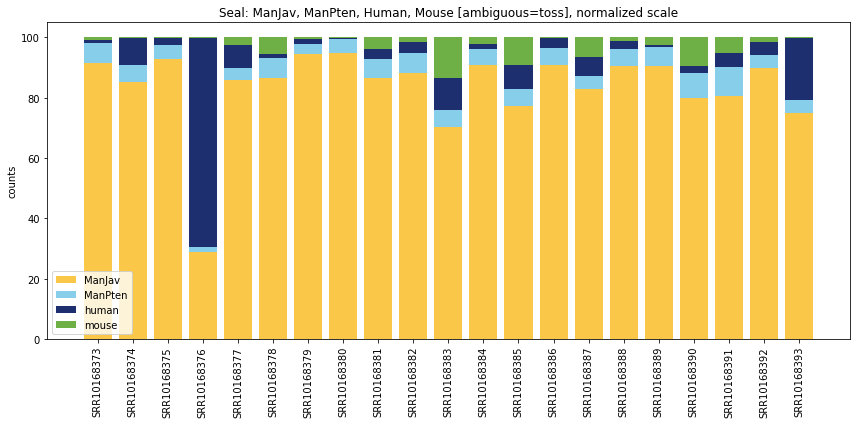

In [14]:
y_scale='normalized'
y_scale_txt = y_scale.replace("'", "")
file_name=f'seal_{aln_params}_{aln_type}_{alb_abbr}_{y_scale_txt}'

#title=f"Seal: ManJav, ManPten, Human, Mouse [ambiguous={aln_params.split('_')[1]}], {y_scale_txt} and normalized scales"
#plot_flagtools_stackplots(frames, file_name, mapped_names, title, y_scale=y_scale, fig_width=12, save_fig=True)

title=f"Seal: ManJav, ManPten, Human, Mouse [ambiguous={aln_params.split('_')[1]}], {y_scale_txt} scale"
plot_flagtools_single_stackplots(frames, file_name, mapped_names, title, y_scale=y_scale, fig_width=12, save_fig=False)

In [15]:
alb_abbr='mp_hu_mus_cp'
aln_type='megahit'
aln_params='default_all'

In [16]:
frames=refstats_df(mapped_names, alb_abbr, aln_type, aln_params)

saving to seal_default_all_megahit_mp_hu_mus_cp_normalized_df.csv


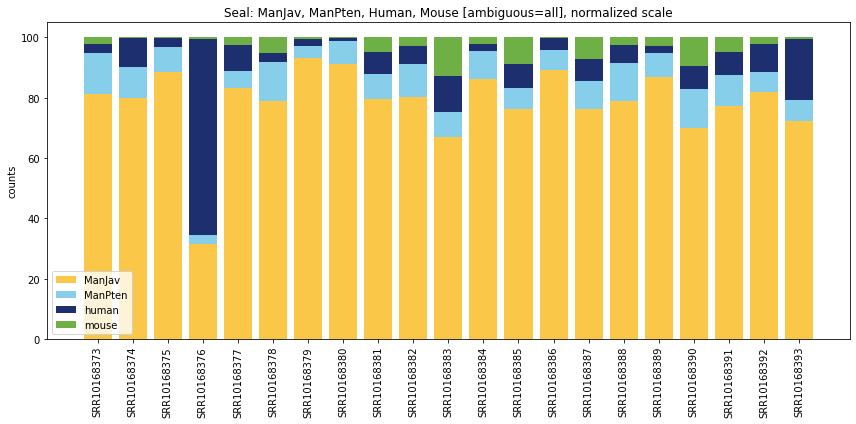

In [17]:
y_scale='normalized'
y_scale_txt = y_scale.replace("'", "")
file_name=f'seal_{aln_params}_{aln_type}_{alb_abbr}_{y_scale_txt}'

#title=f"Seal: ManJav, ManPten, Human, Mouse [ambiguous={aln_params.split('_')[1]}], {y_scale_txt} and normalized scales"
#plot_flagtools_stackplots(frames, file_name, mapped_names, title, y_scale=y_scale, fig_width=16, save_fig=True)

title=f"Seal: ManJav, ManPten, Human, Mouse [ambiguous={aln_params.split('_')[1]}], {y_scale_txt} scale"
plot_flagtools_single_stackplots(frames, file_name, mapped_names, title, y_scale=y_scale, fig_width=12, save_fig=False)